# HypyerParmeter Tuning

ML Model의 최적화를 위해 하이퍼파라미터 튜닝을 진행하는 방법으로 다음의 3가지 방법을 소개한다.

- validation_curve
    - 단일 하이퍼파라미터 튜닝

- GridSearchCV
    - 그리드를 사용한 복수 하이퍼파라미터 튜닝

- ParameterGrid
    - 복수 파라미터 최적화용 그리드

# validation_curve

In [4]:
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.model_selection import validation_curve

digits = load_digits()
X, y = digits.data, digits.target

# 로그스케일에서 균등한 간격으로 Array반환
# 10의 -6승 ~ 10의 -1승을 10개로 쪼갠 Array
param_range = np.logspace(-6, -1, 10)
param_range

array([1.00000000e-06, 3.59381366e-06, 1.29154967e-05, 4.64158883e-05,
       1.66810054e-04, 5.99484250e-04, 2.15443469e-03, 7.74263683e-03,
       2.78255940e-02, 1.00000000e-01])

In [6]:
# RBF 커널 gamma 하이퍼파라미터 튜닝
# 로그스케일로 튜닝하는 것이 효율적

%%time

train_scores, test_scores = validation_curve(SVC(), X, y, 
                                             param_name='gamma',param_range = param_range, 
                                             cv=10, scoring='accuracy', n_jobs=1)

Wall time: 47.1 s


- 10종류의 파라미터를 테스트하는데 한 Fold에서 10번의 검증을 수행, 총 100번 ACC 계산

- n_jobs 의 디폴트 값은 1이며 이 값을 증가시키면 내부적으로 멀티 프로세스를 사용한다. 따라서 CPU 코어의 수가 충분하다면 n_jobs를 늘려 수행 속도를 빠르게 할 수 있다.

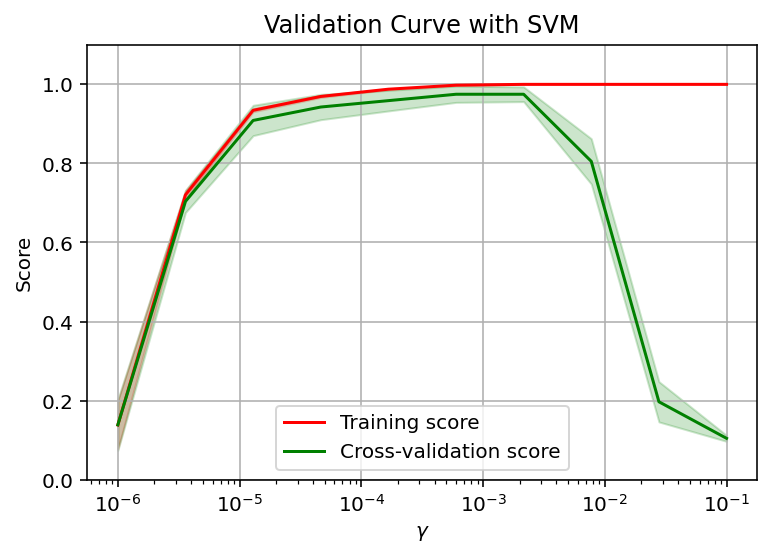

In [8]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

mpl.rcParams["font.family"] = 'DejaVu Sans'
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean,
             label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.grid()
plt.show()

위 Curve를 확인해보면 로그스케일을 이용해 굉장히 큰 값에서 굉장히 작은 값으로 튜닝을 진행했기에 gamma값이 어떤 구간에서 최적의 성능을 보이는지 확인할 수 있다. 따라서 위 Curve에서 얻은 정보를 이용해 해당 구간에서 반복해 Curve를 그리는 방법으로 gamma값을 조정하면 된다.

In [10]:
%%time

param_range = np.logspace(-3, -2, 10)

train_scores, test_scores = validation_curve(SVC(), X, y, 
                                             param_name='gamma',param_range = param_range, 
                                             cv=10, scoring='accuracy', n_jobs=1)

Wall time: 45.2 s


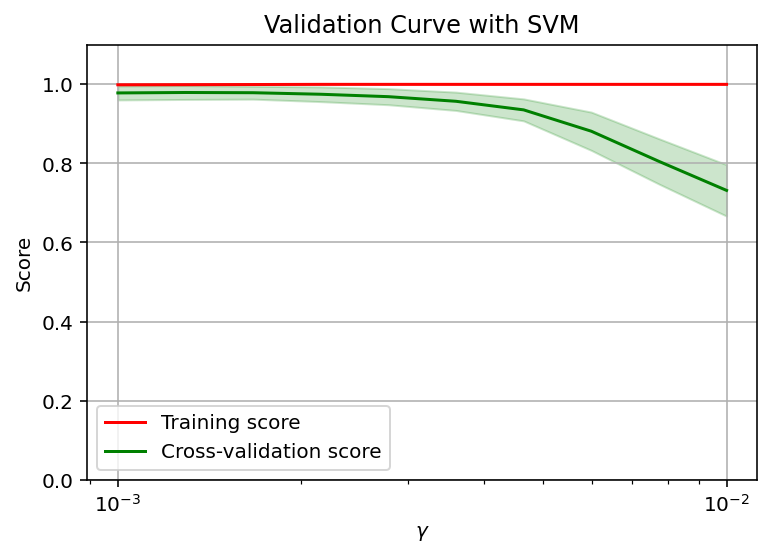

In [11]:
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

mpl.rcParams["font.family"] = 'DejaVu Sans'
plt.semilogx(param_range, train_scores_mean, label="Training score", color="r")
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2, color="r")
plt.semilogx(param_range, test_scores_mean,
             label="Cross-validation score", color="g")
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2, color="g")
plt.legend(loc="best")
plt.title("Validation Curve with SVM")
plt.xlabel("$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
plt.grid()
plt.show()

위 Curve를 통해 $10^{-3}$이 최적의 gamma값임을 확인할 수 있다.

# GridSearchCV

GridSearchCV는 복수의 하이퍼파라미터를 조정하기 위해 사용한다. 

- grid_scores_
    - 모든 파라미터 조합에 대한 성능
- parameters : 사용된 파라미터
- mean_validation_score: 교차검증 평균값
- cv_validation_scores : 교차검증 결과
- best_scores_
    - 최고 점수
- best_params_
    - 최적의 파라미터 조합
- best_estimator_
    - 최적의 모형

In [22]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

# 스케일링 파이프라인 생성
pipe_svc = Pipeline([
    ('scl', StandardScaler()),
    ('clf', SVC())
])

# param_range 지정
param_range = np.logspace(-4,3,8)

# param_grid 지정
param_grid = [
    {'clf__C': param_range, 'clf__kernel':['linear']},
    {'clf__C': param_range, 'clf__gamma': param_range, 'clf__kernel': ['rbf']}
]

# GridSearchCV 진행
gs = GridSearchCV(estimator=pipe_svc, param_grid=param_grid,
                 scoring='accuracy', cv=10, n_jobs=1)

%time gs = gs.fit(X, y)

Wall time: 4min 32s


In [23]:
gs.cv_results_["params"]

[{'clf__C': 0.0001, 'clf__kernel': 'linear'},
 {'clf__C': 0.001, 'clf__kernel': 'linear'},
 {'clf__C': 0.01, 'clf__kernel': 'linear'},
 {'clf__C': 0.1, 'clf__kernel': 'linear'},
 {'clf__C': 1.0, 'clf__kernel': 'linear'},
 {'clf__C': 10.0, 'clf__kernel': 'linear'},
 {'clf__C': 100.0, 'clf__kernel': 'linear'},
 {'clf__C': 1000.0, 'clf__kernel': 'linear'},
 {'clf__C': 0.0001, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 0.1, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 1.0, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 10.0, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 100.0, 'clf__kernel': 'rbf'},
 {'clf__C': 0.0001, 'clf__gamma': 1000.0, 'clf__kernel': 'rbf'},
 {'clf__C': 0.001, 'clf__gamma': 0.0001, 'clf__kernel': 'rbf'},
 {'clf__C': 0.001, 'clf__gamma': 0.001, 'clf__kernel': 'rbf'},
 {'clf__C

In [24]:
gs.cv_results_["mean_test_score"]

array([0.23120112, 0.91485413, 0.95046245, 0.95547176, 0.95658908,
       0.95658908, 0.95658908, 0.95658908, 0.13089385, 0.13536313,
       0.13927374, 0.12418994, 0.1001676 , 0.13089385, 0.10687151,
       0.1001676 , 0.13089385, 0.13536313, 0.13927374, 0.12418994,
       0.1001676 , 0.13089385, 0.10687151, 0.1001676 , 0.13089385,
       0.13536313, 0.14429857, 0.12418994, 0.1001676 , 0.13089385,
       0.10687151, 0.1001676 , 0.13089385, 0.68335816, 0.90761639,
       0.40958101, 0.1001676 , 0.13089385, 0.10687151, 0.1001676 ,
       0.70449721, 0.93153011, 0.96047796, 0.90317505, 0.12469894,
       0.1001676 , 0.10128492, 0.1001676 , 0.93264742, 0.95547176,
       0.96937927, 0.90540348, 0.13416511, 0.1001676 , 0.10128492,
       0.1001676 , 0.95547796, 0.96047796, 0.96937927, 0.90540348,
       0.13416511, 0.1001676 , 0.10128492, 0.1001676 , 0.95825885,
       0.95935754, 0.96937927, 0.90540348, 0.13416511, 0.1001676 ,
       0.10128492, 0.1001676 ])

In [25]:
print(gs.best_score_)
print(gs.best_params_)

0.969379267535692
{'clf__C': 10.0, 'clf__gamma': 0.01, 'clf__kernel': 'rbf'}


# ParameterGrid

ParameterGrid는 파라미터를 조합해 그리드를 생성하는 역할을 수행한다.

In [26]:
from sklearn.model_selection import ParameterGrid

param_grid = {'a': [1, 2], 'b': [True, False]}
list(ParameterGrid(param_grid))

[{'a': 1, 'b': True},
 {'a': 1, 'b': False},
 {'a': 2, 'b': True},
 {'a': 2, 'b': False}]

In [27]:
param_grid = [{'kernel': ['linear']}, {'kernel': ['rbf'], 'gamma': [1, 10]}]
list(ParameterGrid(param_grid))

[{'kernel': 'linear'},
 {'gamma': 1, 'kernel': 'rbf'},
 {'gamma': 10, 'kernel': 'rbf'}]